In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

%matplotlib inline

In [2]:
cols1 = ["frame", "xmin", "ymin", "xmax", "ymax", "occluded", "label", "attributes"]
df1 = pd.read_csv('resources/udacity-dataset/object-dataset/labels.csv', names=cols1, delimiter=' ')
df1 = df1.query("label != 'trafficLight' and label != 'biker'")
df1.drop(['occluded', 'attributes'], axis=1, inplace=True)
df1.frame = 'object-dataset/' + df1.frame
df1 = df1.reset_index(drop=True)

cols2 = ["xmin", "ymin", "xmax", "ymax", "frame", "label"]
df2 = pd.read_csv('resources/udacity-dataset/object-detection-crowdai/labels_crowdai.csv')
df2.drop('Preview URL', axis=1, inplace=True)
df2.columns = cols2
df2['label'] = df2['label'].str.lower()
df2.frame = 'object-detection-crowdai/' + df2.frame

In [3]:
print('df1.shape', df1.shape)
print('df2.shape', df2.shape)

df1.shape (74157, 6)
df2.shape (72064, 6)


In [4]:
df1.head()

,frame,xmin,ymin,xmax,ymax,label
0,object-dataset/1478019952686311006.jpg,950,574,1004,620,car
1,object-dataset/1478019952686311006.jpg,1748,482,1818,744,pedestrian
2,object-dataset/1478019953180167674.jpg,872,586,926,632,car
3,object-dataset/1478019953689774621.jpg,686,566,728,618,truck
4,object-dataset/1478019953689774621.jpg,716,578,764,622,car


In [5]:
df2.head()

,xmin,ymin,xmax,ymax,frame,label
0,785,533,905,644,object-detection-crowdai/1479498371963069978.jpg,car
1,89,551,291,680,object-detection-crowdai/1479498371963069978.jpg,car
2,268,546,383,650,object-detection-crowdai/1479498371963069978.jpg,car
3,455,522,548,615,object-detection-crowdai/1479498371963069978.jpg,truck
4,548,522,625,605,object-detection-crowdai/1479498371963069978.jpg,truck


In [6]:
grp1 = df1.groupby('label').size()
grp1 / grp1.sum() * 100

label
car           81.972032
pedestrian    13.304206
truck          4.723762
dtype: float64

In [7]:
grp2 = df2.groupby('label').size()
grp2 / grp2.sum() * 100

label
car           86.825599
pedestrian     7.874944
truck          5.299456
dtype: float64

In [8]:
df = pd.concat([df1, df2], axis=0)
df.head()

,frame,label,xmax,xmin,ymax,ymin
0,object-dataset/1478019952686311006.jpg,car,1004,950,620,574
1,object-dataset/1478019952686311006.jpg,pedestrian,1818,1748,744,482
2,object-dataset/1478019953180167674.jpg,car,926,872,632,586
3,object-dataset/1478019953689774621.jpg,truck,728,686,618,566
4,object-dataset/1478019953689774621.jpg,car,764,716,622,578


In [9]:
df.label = np.where(df.label == 'truck', 'car', df.label)
# df.label = np.where(df.label != 'car', 'non-car', df.label)
# df.label = df.label.astype('category')

In [10]:
df.head()

,frame,label,xmax,xmin,ymax,ymin
0,object-dataset/1478019952686311006.jpg,car,1004,950,620,574
1,object-dataset/1478019952686311006.jpg,pedestrian,1818,1748,744,482
2,object-dataset/1478019953180167674.jpg,car,926,872,632,586
3,object-dataset/1478019953689774621.jpg,car,728,686,618,566
4,object-dataset/1478019953689774621.jpg,car,764,716,622,578


In [11]:
grp = df.groupby('label').size()
grp / grp.sum() * 100

label
car           89.371568
pedestrian    10.628432
dtype: float64

In [12]:
df.shape

(146221, 6)

In [13]:
df[df.xmax == 0]

,frame,label,xmax,xmin,ymax,ymin


In [14]:
df[df.ymax == 0] # this is error (ymax shouldn't be zero)

,frame,label,xmax,xmin,ymax,ymin
3051,object-detection-crowdai/1479498564477313399.jpg,car,951,912,0,0
5482,object-detection-crowdai/1479498820473341507.jpg,car,732,705,0,0
13486,object-detection-crowdai/1479499937073018706.jpg,car,751,721,0,0
58312,object-detection-crowdai/1479505030914958665.jpg,pedestrian,793,763,0,0


In [15]:
df = df[df.ymax != 0]
df.shape

(146217, 6)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146217 entries, 0 to 72063
Data columns (total 6 columns):
frame    146217 non-null object
label    146217 non-null object
xmax     146217 non-null int64
xmin     146217 non-null int64
ymax     146217 non-null int64
ymin     146217 non-null int64
dtypes: int64(4), object(2)
memory usage: 7.8+ MB


In [17]:
# classes = ['background'] + list(df.label.unique())
classes = df.label.unique()
le = LabelEncoder()
le.fit(classes)
classes

array(['car', 'pedestrian'], dtype=object)

In [18]:
print(le.transform(['car']))
print(le.transform(['pedestrian']))

[0]
[1]


In [19]:
def draw(key):
    image = mpimg.imread('resources/udacity-dataset/' + key)
    data = df[df.frame == key]
    colors = plt.cm.hsv(np.linspace(0, 0.5, len(classes))).tolist()
    
    ax = plt.gca()
    for idx, img in data.iterrows():
        cv2.rectangle(image, (img.xmin, img.ymin), (img.xmax, img.ymax),(0, 255, 0), 6)
        coords = (img.xmin, img.ymin), img.xmax-img.xmin+1, img.ymax-img.ymin+1
        color = colors[le.transform([img.label])[0]]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        ax.text(img.xmin, img.ymin, img.label, bbox={'facecolor':color, 'alpha':0.5})

    plt.imshow(image)

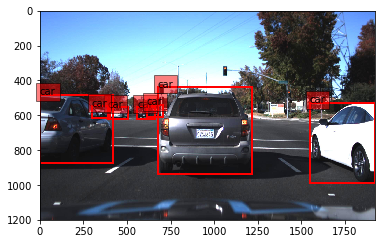

In [20]:
draw('object-detection-crowdai/1479502217225257061.jpg')

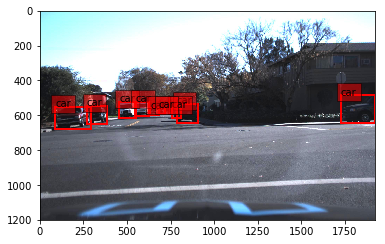

In [21]:
draw('object-detection-crowdai/1479498371963069978.jpg')

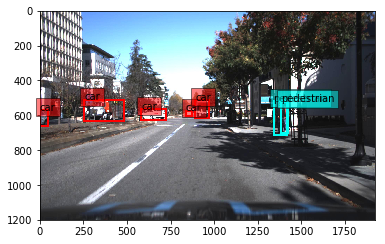

In [22]:
draw('object-detection-crowdai/1479503036282378933.jpg')

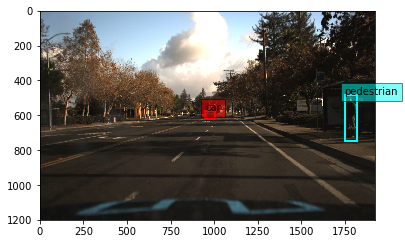

In [23]:
draw('object-dataset/1478019952686311006.jpg')

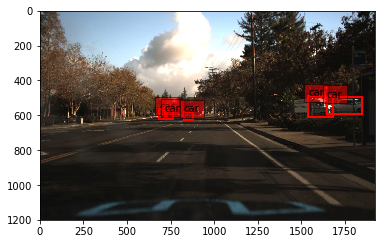

In [24]:
draw('object-dataset/1478019953689774621.jpg')

In [25]:
# occluded = df[df['occluded'] == 1].reset_index(drop=True)
# occluded[occluded.frame == '1478019953689774621.jpg']
# # occluded
# draw(occluded[occluded.frame == '1478019953689774621.jpg'])

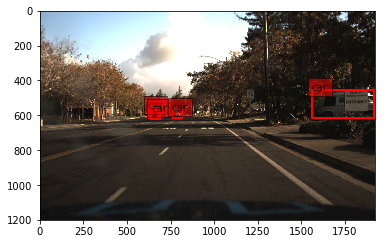

In [26]:
draw('object-dataset/1478019955185244088.jpg')

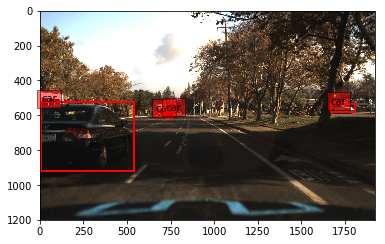

In [27]:
draw('object-dataset/1478019959681353555.jpg')

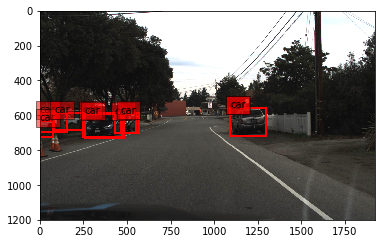

In [28]:
draw('object-dataset/1478901535246276321.jpg')

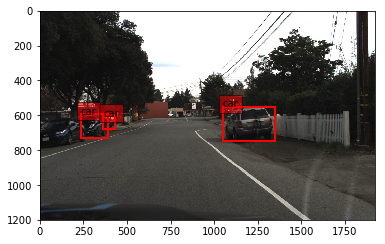

In [29]:
draw('object-dataset/1478901536388465963.jpg')

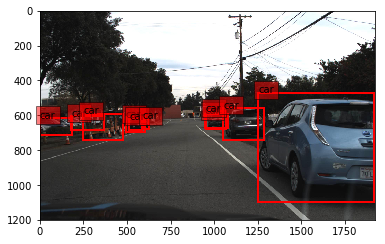

In [30]:
draw('object-dataset/1478901532389636298.jpg')

## Verify both datasets have images of the same size

In [31]:
img = mpimg.imread('resources/udacity-dataset/object-dataset/1478901536960505700.jpg')
h, w, _ = img.shape
img.shape # both datasets have images of the same shape

(1200, 1920, 3)

In [32]:
img = mpimg.imread('resources/udacity-dataset/object-detection-crowdai/1479498371963069978.jpg')
h, w, _ = img.shape
img.shape # both datasets have images of the same shape

(1200, 1920, 3)

coordinates of the object(s) in the image,eg: (x/img_width, y/img_height, (x+w)/img_width, (y+h)/img_height).

In [33]:
df.xmin = df.xmin / w
df.xmax = df.xmax / w

df.ymin = df.ymin / h
df.ymax = df.ymax / h

In [34]:
# classes = ['background'] + list(df.label.unique()) # take background class into account
classes = list(df.label.unique()) # ignore background
lb = LabelBinarizer()
y = lb.fit_transform(classes)
print(lb.classes_)

lb.transform(['background', 'car', 'pedestrian', 'truck', 'car', 'pedestrian'])

['car' 'pedestrian']


array([[0, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 1]])

In [35]:
df.head()

,frame,label,xmax,xmin,ymax,ymin
0,object-dataset/1478019952686311006.jpg,car,0.522917,0.494792,0.516667,0.478333
1,object-dataset/1478019952686311006.jpg,pedestrian,0.946875,0.910417,0.620000,0.401667
2,object-dataset/1478019953180167674.jpg,car,0.482292,0.454167,0.526667,0.488333
3,object-dataset/1478019953689774621.jpg,car,0.379167,0.357292,0.515000,0.471667
4,object-dataset/1478019953689774621.jpg,car,0.397917,0.372917,0.518333,0.481667


In [36]:
gt = pickle.load(open('gt_pascal.pkl', 'rb'))
gt

{'frame02089.png': array([[ 0.5625    ,  0.09861111,  0.790625  ,  0.46805556,  1.        ,
          0.        ,  0.        ],
        [ 0.403125  ,  0.38055556,  0.509375  ,  0.81944444,  1.        ,
          0.        ,  0.        ]]),
 'frame04694.png': array([[ 0.4109375 ,  0.05416667,  0.6328125 ,  0.30694444,  0.        ,
          0.        ,  1.        ]]),
 'frame04594.png': array([[ 0.234375  ,  0.16944444,  0.31875   ,  0.65277778,  0.        ,
          1.        ,  0.        ],
        [ 0.61015625,  0.34027778,  0.75234375,  0.7375    ,  0.        ,
          0.        ,  1.        ]]),
 'frame03254.png': array([[  4.98437500e-01,  -1.38777878e-17,   7.60937500e-01,
           2.16666667e-01,   1.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  2.72656250e-01,   3.93055556e-01,   3.96093750e-01,
           8.62500000e-01,   0.00000000e+00,   1.00000000e+00,
           0.00000000e+00]]),
 'frame04175.png': array([[ 0.2296875 ,  0.01388889,  0.382812

In [37]:
dataset = dict()
for idx, row in df.iterrows():
    coords = [row.xmin, row.ymin, row.xmax, row.ymax]
    label_encoded = lb.transform([row.label]).ravel()
    val = np.array([np.hstack((coords, label_encoded))])
    
    current = dataset.get(row.frame)
    if current is None:
        dataset[row.frame] = val
    else:
        dataset[row.frame] = np.vstack((current, val))
dataset

{'object-dataset/1478019952686311006.jpg': array([[ 0.49479167,  0.47833333,  0.52291667,  0.51666667,  0.        ],
        [ 0.91041667,  0.40166667,  0.946875  ,  0.62      ,  1.        ]]),
 'object-dataset/1478019953180167674.jpg': array([[ 0.45416667,  0.48833333,  0.48229167,  0.52666667,  0.        ]]),
 'object-dataset/1478019953689774621.jpg': array([[ 0.35729167,  0.47166667,  0.37916667,  0.515     ,  0.        ],
        [ 0.37291667,  0.48166667,  0.39791667,  0.51833333,  0.        ],
        [ 0.43020833,  0.48333333,  0.45833333,  0.52166667,  0.        ],
        [ 0.80208333,  0.40666667,  0.875     ,  0.50666667,  0.        ],
        [ 0.85729167,  0.415     ,  0.9625    ,  0.495     ,  0.        ]]),
 'object-dataset/1478019954186238236.jpg': array([[ 0.34479167,  0.46833333,  0.36979167,  0.51333333,  0.        ],
        [ 0.35729167,  0.48      ,  0.38020833,  0.52333333,  0.        ],
        [ 0.41770833,  0.485     ,  0.44583333,  0.52333333,  0.        ],
 

In [38]:
pickle.dump(dataset, open("no-background-ground-truth.pkl", "wb"))

In [39]:
len(dataset)

22183